In [48]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras



In [2]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 

In [3]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load('cifar10', split=train_split, with_info=True)
vaild_data = tfds.load('cifar10', split=valid_split)
test_data = tfds.load('cifar10', split='test')
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [4]:
label_dict = dict(enumerate(info.features['label'].names))
print(label_dict)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [6]:
train_dict = {}
for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


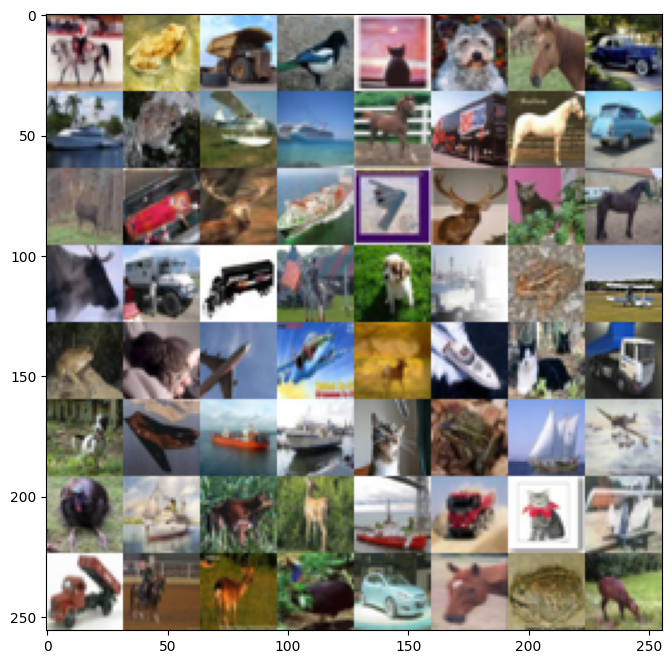

In [5]:
output = np.zeros((32*8,32*8,3), dtype=np.uint8)
row = 0
for  data in train_data.batch(8).take(8):
    output[:,row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
plt.figure(figsize=(8,8))
plt.imshow(output)

In [7]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.0
    y = tf.one_hot(dataset['label'], depth=10)
    return x, y

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_num = int(info.splits['train'].num_examples/10)*9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
vaild_data = vaild_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
vaild_data = vaild_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [9]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1315

In [45]:
model_dir = 'lab4-logs/models/'
os.makedirs(model_dir, exist_ok=True)

log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mcbk = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', monitor='val_categorical_accuracy', save_best_only=True, mode='max')


In [11]:
model_1.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
history1 = model_1.fit(train_data, epochs=100, validation_data=vaild_data, callbacks=[model_cbk, model_mcbk])

Epoch 1/100
  1/704 [..............................] - ETA: 0s - loss: 2.4266 - categorical_accuracy: 0.0781WARNING:tensorflow:From c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/704 [..............................] - ETA: 31s - loss: 2.3787 - categorical_accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0065s vs `on_train_batch_end` time: 0.0806s). Check your callbacks.


704/704 [==============================] - 4s 6ms/step - loss: 2.1648 - categorical_accuracy: 0.1593 - val_loss: 2.1492 - val_categorical_accuracy: 0.1610
Epoch 2/100
704/704 [==============================] - 6s 8ms/step - loss: 2.1247 - categorical_accuracy: 0.1731 - val_loss: 2.0816 - val_categorical_accuracy: 0.1932
Epoch 3/100
704/704 [==============================] - 6s 8ms/step - loss: 2.1066 - categorical_accuracy: 0.1874 - val_loss: 2.0306 - val_categorical_accuracy: 0.2200
Epoch 4/100
704/704 [==============================] - 3s 5ms/step - loss: 2.0972 - categorical_accuracy: 0.1940 - val_loss: 2.0680 - val_categorical_accuracy: 0.2034
Epoch 5/100
704/704 [==============================] - 8s 11ms/step - loss: 2.0840 - categorical_accuracy: 0.1970 - val_loss: 2.0443 - val_categorical_accuracy: 0.2252
Epoch 6/100
704/704 [==============================] - 3s 5ms/step - loss: 2.0819 - categorical_accuracy: 0.2017 - val_loss: 2.0409 - val_categorical_accuracy: 0.2248
Epoch 7/1

In [13]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [14]:
model_dir = 'lab4-logs/models/'
os.makedirs(model_dir, exist_ok=True)

log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mcbk = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', monitor='val_categorical_accuracy', save_best_only=True, mode='max')

model_2.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
history2 = model_2.fit(train_data, epochs=100, validation_data=vaild_data, callbacks=[model_cbk, model_mcbk])

Epoch 1/100
  2/704 [..............................] - ETA: 34s - loss: 2.3092 - categorical_accuracy: 0.0938WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0074s vs `on_train_batch_end` time: 0.0896s). Check your callbacks.


704/704 [==============================] - 10s 14ms/step - loss: 1.8454 - categorical_accuracy: 0.3077 - val_loss: 1.5450 - val_categorical_accuracy: 0.4372
Epoch 2/100
704/704 [==============================] - 9s 13ms/step - loss: 1.4839 - categorical_accuracy: 0.4615 - val_loss: 1.3154 - val_categorical_accuracy: 0.5138
Epoch 3/100
704/704 [==============================] - 10s 14ms/step - loss: 1.3288 - categorical_accuracy: 0.5235 - val_loss: 1.2639 - val_categorical_accuracy: 0.5462
Epoch 4/100
704/704 [==============================] - 10s 14ms/step - loss: 1.2007 - categorical_accuracy: 0.5784 - val_loss: 1.0872 - val_categorical_accuracy: 0.6128
Epoch 5/100
704/704 [==============================] - 9s 13ms/step - loss: 1.0959 - categorical_accuracy: 0.6150 - val_loss: 0.9797 - val_categorical_accuracy: 0.6454
Epoch 6/100
704/704 [==============================] - 9s 13ms/step - loss: 1.0198 - categorical_accuracy: 0.6431 - val_loss: 0.9236 - val_categorical_accuracy: 0.6688
E

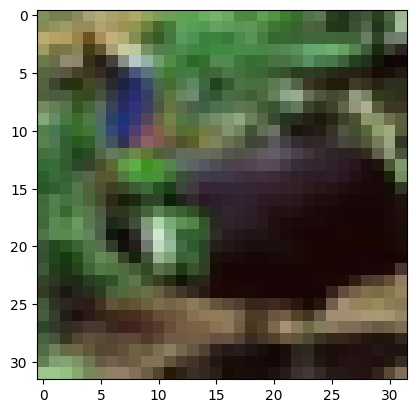

In [10]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32]
plt.imshow(image_test)

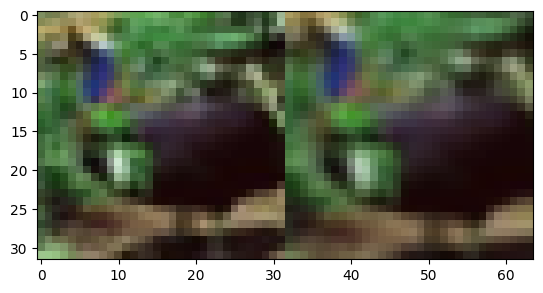

In [36]:
def zoom(x,scale_min=0.6, scale_max=1.4):
    h, w, = x.shape[0], x.shape[1]
    scale = np.random.uniform(scale_min, scale_max)
    new_h, new_w = int(h*scale), int(w*scale)
    x = tf.image.resize(x, (new_h, new_w))
    x = tf.image.resize_with_crop_or_pad(x, h, w)
    return x

def flip(x):
    x = tf.image.random_flip_left_right(x)
    return x
zoom_image = zoom(x=image_test)
zoom_image = tf.cast(zoom_image, tf.uint8)
image = np.hstack((image_test, zoom_image))
plt.imshow(image)


In [38]:
train_data = tfds.load('cifar10', split=train_split)


In [39]:
def parse_aug_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.0
    x = flip(x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    y = tf.one_hot(dataset['label'], depth=10)
    return x, y


In [40]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)



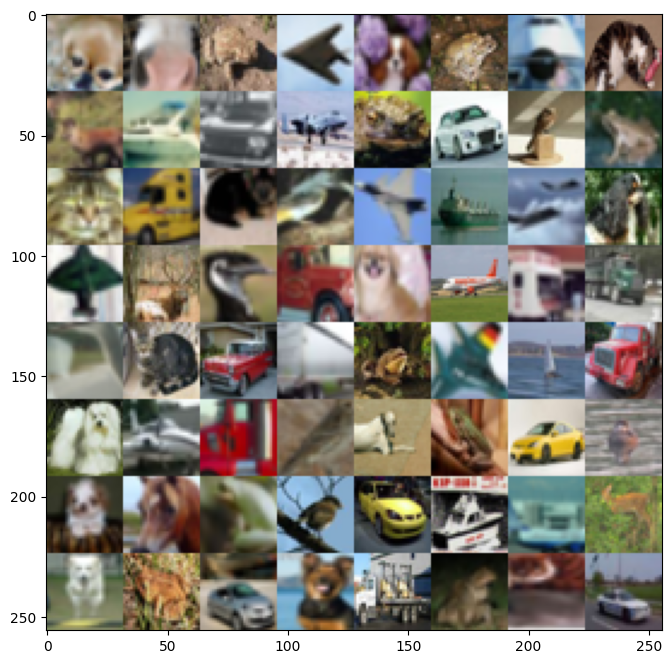

In [42]:
for images, labels in train_data.take(1):
    images = images.numpy()

output = np.zeros((32*8,32*8,3))

for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]

plt.figure(figsize=(8,8))
plt.imshow(output)


In [43]:
input= keras.Input(shape=(32,32,3))
x = layers.Conv2D(64, 3, activation='relu')(input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation='softmax')(x)

model_3 = keras.Model(input, output, name='model-3')

model_3.summary()

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [46]:
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mcbk = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', monitor='val_categorical_accuracy', save_best_only=True, mode='max')

model_3.compile(keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
history3 = model_3.fit(train_data, epochs=100, validation_data=vaild_data, callbacks=[model_cbk, model_mcbk])

Epoch 1/100
  1/704 [..............................] - ETA: 0s - loss: 2.3009 - categorical_accuracy: 0.0781WARNING:tensorflow:From c:\Users\ASUS\anaconda3\envs\tf2_NTUT\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/704 [..............................] - ETA: 32s - loss: 2.3056 - categorical_accuracy: 0.0703WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.0840s). Check your callbacks.


704/704 [==============================] - 11s 15ms/step - loss: 1.9139 - categorical_accuracy: 0.2819 - val_loss: 1.5373 - val_categorical_accuracy: 0.4404
Epoch 2/100
704/704 [==============================] - 10s 15ms/step - loss: 1.6129 - categorical_accuracy: 0.4089 - val_loss: 1.3197 - val_categorical_accuracy: 0.5126
Epoch 3/100
704/704 [==============================] - 9s 13ms/step - loss: 1.4640 - categorical_accuracy: 0.4778 - val_loss: 1.2474 - val_categorical_accuracy: 0.5466
Epoch 4/100
704/704 [==============================] - 15s 21ms/step - loss: 1.3735 - categorical_accuracy: 0.5143 - val_loss: 1.1506 - val_categorical_accuracy: 0.5946
Epoch 5/100
704/704 [==============================] - 11s 15ms/step - loss: 1.2800 - categorical_accuracy: 0.5530 - val_loss: 1.0795 - val_categorical_accuracy: 0.6150
Epoch 6/100
704/704 [==============================] - 10s 14ms/step - loss: 1.2119 - categorical_accuracy: 0.5794 - val_loss: 1.0159 - val_categorical_accuracy: 0.6356

KeyboardInterrupt: 

In [49]:
model_1 = keras.models.load_model('lab4-logs/models/Best-model-1.h5')
model_2 = keras.models.load_model('lab4-logs/models/Best-model-2.h5')
model_3 = keras.models.load_model('lab4-logs/models/Best-model-3.h5')

loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]
dict = {'loss':loss, 'acc':acc}
df = pd.DataFrame(dict)



157/157 [==============================] - 4s 24ms/step - loss: 0.8574 - categorical_accuracy: 0.7881
